# Step 3: Build Embeddings + FAISS Index
**Approximate Nearest Neighbors Search for Fashion Recommendation**

## 🎯 Business Problem
When a product goes **OUT OF STOCK**, the e-commerce store loses the customer. This system **keeps them engaged** by instantly recommending similar available items.

## 📊 System Architecture

```
Dummy Shop (Frontend)
        ↓
        ↓ User clicks: "Product #457 - OUT OF STOCK"
        ↓
        ↓ API Call: "Give me 5 similar items"
        ↓
   Recommender Service (This Notebook)
        ↓
        ├─ Load Product #457's features (512-dim embedding)
        ├─ Query FAISS Index: "Find 5 nearest neighbors"
        ├─ Use L2 distance to rank by similarity
        └─ Return: [Product_A, Product_B, Product_C, Product_D, Product_E]
        ↓
   Inventory Catalog (DeepFashion Dataset)
        ↓
        ↓ Display: "SIMILAR ITEMS AVAILABLE"
        ↓ Show 5 images + prices + availability
        ↓
   User clicks alternative → STAYS IN STORE ✅
```

## 🔧 What This Notebook Does

1. **Loads trained model** from Step 2 (export.pkl)
2. **Extracts embeddings** for all 13k+ fashion items
   - Each image → 512-dimensional feature vector
   - Captures visual similarity (color, style, texture, fit)
3. **Builds FAISS Index** for fast ANN lookup
   - Millisecond-level search vs sequential scan
   - Scalable to 100k+ products
4. **Tests system** with real query → visualizes top-5 recommendations

## 💾 Output Artifacts (Saved to `/Index/`)
- `faiss_index.bin` - The searchable index
- `embeddings.npy` - All product embeddings
- `valid_indices.npy` - Mapping to product IDs
- `products.pkl` - Product metadata (images, categories, prices)

In [2]:
%pip install -q faiss-cpu scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import faiss
from fastai.vision.all import *

# Setup paths
ROOT_DIR = Path.cwd().parent
DATA_DIR = ROOT_DIR / "Data"
MODELS_DIR = ROOT_DIR / "Models"
INDEX_DIR = ROOT_DIR / "Index"
INDEX_DIR.mkdir(parents=True, exist_ok=True)

print("ROOT_DIR:", ROOT_DIR)
print("DATA_DIR:", DATA_DIR)
print("MODELS_DIR:", MODELS_DIR)
print("INDEX_DIR:", INDEX_DIR)

ROOT_DIR: /Users/ganenthraravindran/Desktop/Fashion Recommender
DATA_DIR: /Users/ganenthraravindran/Desktop/Fashion Recommender/Data
MODELS_DIR: /Users/ganenthraravindran/Desktop/Fashion Recommender/Models
INDEX_DIR: /Users/ganenthraravindran/Desktop/Fashion Recommender/Index


In [4]:
## Load Product Dataset
bbox_path = DATA_DIR / "list_bbox_inshop.txt"

bbox_df = pd.read_csv(
    bbox_path,
    delim_whitespace=True,
    header=None,
    skiprows=2,
)

bbox_df.columns = ["image_path", "clothes_type", "pose_type", "x1", "y1", "x2", "y2"]

# Build products DataFrame
products = bbox_df[["image_path"]].copy()
products["category_raw"] = products["image_path"].str.split("/").str[2]

products["category"] = (
    products["category_raw"]
      .str.replace("Blouses_Shirts", "Blouse")
      .str.replace("Tees_Tanks", "Tee", regex=False)
      .str.replace("Dresses", "Dress", regex=False)
      .str.replace("Shorts", "Shorts", regex=False)
      .str.replace("Skirts", "Skirt", regex=False)
      .str.replace("Sweaters", "Sweater", regex=False)
      .str.replace("Cardigans", "Cardigan", regex=False)
      .str.replace("Jackets_Coats", "Jacket", regex=False)
)

products = products.reset_index(drop=True)
products["product_id"] = products.index + 1

print(f"Total products: {len(products)}")
print(f"Products shape: {products.shape}")
print(products.head())

/var/folders/m_/ptg0zwqn0b34bnnmgnqwtkvm0000gn/T/ipykernel_34297/3007796245.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  bbox_df = pd.read_csv(


Total products: 52712
Products shape: (52712, 4)
                                            image_path    category_raw  \
0  img/WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg  Blouses_Shirts   
1   img/WOMEN/Blouses_Shirts/id_00000001/02_2_side.jpg  Blouses_Shirts   
2   img/WOMEN/Blouses_Shirts/id_00000001/02_3_back.jpg  Blouses_Shirts   
3   img/WOMEN/Blouses_Shirts/id_00000001/02_4_full.jpg  Blouses_Shirts   
4         img/WOMEN/Dresses/id_00000002/02_1_front.jpg         Dresses   

  category  product_id  
0   Blouse           1  
1   Blouse           2  
2   Blouse           3  
3   Blouse           4  
4    Dress           5  


In [5]:
## Load Trained Model
export_path = MODELS_DIR / "export.pkl"
print(f"Loading model from: {export_path}")

if not export_path.exists():
    raise FileNotFoundError(f"Model not found at {export_path}. Please run Step 2 first.")

learn = load_learner(export_path)
print("✓ Model loaded successfully")
print(f"Model: {learn.model}")

Loading model from: /Users/ganenthraravindran/Desktop/Fashion Recommender/Models/export.pkl
✓ Model loaded successfully
Model: Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [6]:
## Extract Embeddings from All Products
def get_embeddings_batch(learn, products_df, data_dir, batch_size=32):
    """
    Extract embeddings for all products efficiently.
    Uses hooks to capture features from the penultimate layer.
    """
    embeddings_list = []
    valid_indices = []
    failed_count = 0
    
    # Register hook to capture intermediate layer output
    activation = {}
    def get_hook(name):
        def hook(model, input, output):
            activation[name] = output.detach().cpu()
        return hook
    
    # Hook into the final average pooling layer (before classification head)
    hook_handle = learn.model[1][0].register_forward_hook(get_hook('features'))
    
    learn.model.eval()
    
    with torch.no_grad():
        for idx, row in products_df.iterrows():
            try:
                img_path = data_dir / row["image_path"]
                if img_path.exists():
                    # Load and preprocess image
                    img = PILImage.create(img_path)
                    # Get test dataloader for single image
                    test_dl = learn.dls.test_dl([img])
                    pil_images = test_dl.dataset.items
                    # Pass through model
                    _ = learn.model(test_dl.one_batch()[0])
                    # Extract and reshape embeddings
                    emb = activation['features'].squeeze(0).numpy()
                    if emb.ndim > 1:
                        emb = emb.mean(axis=(1, 2)) if emb.ndim == 3 else emb.mean()
                    embeddings_list.append(emb)
                    valid_indices.append(idx)
                else:
                    failed_count += 1
            except Exception as e:
                failed_count += 1
            
            if (idx + 1) % 100 == 0:
                print(f"Processed {idx + 1}/{len(products_df)} products ({failed_count} failed)...")
    
    hook_handle.remove()
    
    embeddings = np.array(embeddings_list, dtype=np.float32)
    valid_indices = np.array(valid_indices)
    
    print(f"\n✓ Extracted {len(embeddings)} embeddings")
    print(f"  Failed: {failed_count}")
    print(f"  Embedding shape: {embeddings.shape}")
    
    return embeddings, valid_indices

print("Extracting embeddings...")
embeddings, valid_indices = get_embeddings_batch(learn, products, DATA_DIR)
print("Done!")

Extracting embeddings...
Processed 100/52712 products (0 failed)...
Processed 200/52712 products (0 failed)...
Processed 300/52712 products (0 failed)...
Processed 400/52712 products (0 failed)...
Processed 500/52712 products (0 failed)...
Processed 600/52712 products (0 failed)...
Processed 700/52712 products (0 failed)...
Processed 800/52712 products (0 failed)...
Processed 900/52712 products (0 failed)...
Processed 1000/52712 products (0 failed)...
Processed 1100/52712 products (0 failed)...
Processed 1200/52712 products (0 failed)...
Processed 1300/52712 products (0 failed)...
Processed 1400/52712 products (0 failed)...
Processed 1500/52712 products (0 failed)...
Processed 1600/52712 products (0 failed)...
Processed 1700/52712 products (0 failed)...
Processed 1800/52712 products (0 failed)...
Processed 1900/52712 products (0 failed)...
Processed 2000/52712 products (0 failed)...
Processed 2100/52712 products (0 failed)...
Processed 2200/52712 products (0 failed)...
Processed 2300/5

In [7]:
## Build FAISS Index
# FAISS requires L2-normalized embeddings for best results with IndexFlatL2
from sklearn.preprocessing import normalize

# Normalize embeddings
embeddings_normalized = normalize(embeddings, norm='l2')

# Create FAISS index
embedding_dim = embeddings_normalized.shape[1]
index = faiss.IndexFlatL2(embedding_dim)
index.add(embeddings_normalized)

print(f"✓ FAISS Index created")
print(f"  Dimension: {embedding_dim}")
print(f"  Number of vectors: {index.ntotal}")

# Save index
index_path = INDEX_DIR / "faiss_index.bin"
faiss.write_index(index, str(index_path))
print(f"✓ Index saved to: {index_path}")

✓ FAISS Index created
  Dimension: 1024
  Number of vectors: 52712
✓ Index saved to: /Users/ganenthraravindran/Desktop/Fashion Recommender/Index/faiss_index.bin


In [8]:
## Save Embeddings and Metadata
embeddings_path = INDEX_DIR / "embeddings.npy"
valid_indices_path = INDEX_DIR / "valid_indices.npy"
products_path = INDEX_DIR / "products.pkl"

np.save(embeddings_path, embeddings_normalized)
np.save(valid_indices_path, valid_indices)
products.iloc[valid_indices].to_pickle(products_path)

print(f"✓ Embeddings saved to: {embeddings_path}")
print(f"✓ Valid indices saved to: {valid_indices_path}")
print(f"✓ Products saved to: {products_path}")

# Create metadata file
metadata = {
    'num_embeddings': len(embeddings),
    'embedding_dimension': embedding_dim,
    'valid_products_count': len(valid_indices),
    'total_products_count': len(products)
}
print(f"\nMetadata:")
for key, value in metadata.items():
    print(f"  {key}: {value}")

✓ Embeddings saved to: /Users/ganenthraravindran/Desktop/Fashion Recommender/Index/embeddings.npy
✓ Valid indices saved to: /Users/ganenthraravindran/Desktop/Fashion Recommender/Index/valid_indices.npy
✓ Products saved to: /Users/ganenthraravindran/Desktop/Fashion Recommender/Index/products.pkl

Metadata:
  num_embeddings: 52712
  embedding_dimension: 1024
  valid_products_count: 52712
  total_products_count: 52712


In [9]:
## Test Recommendation System
from random import randint
import matplotlib.pyplot as plt

def recommend_items(query_idx, index, valid_indices, products_df, data_dir, k=5):
    """
    Find k most similar items using FAISS index.
    """
    # Find position in valid_indices
    pos = np.where(valid_indices == query_idx)[0]
    if len(pos) == 0:
        return None
    
    query_pos = pos[0]
    query_embedding = embeddings_normalized[query_pos].reshape(1, -1)
    
    # Search in FAISS index
    distances, indices = index.search(query_embedding, k+1)
    
    results = []
    for i, idx in enumerate(indices[0]):
        if idx != query_pos:  # Exclude query itself
            actual_product_idx = valid_indices[idx]
            product_info = products_df.iloc[actual_product_idx]
            results.append({
                'product_id': product_info['product_id'],
                'category': product_info['category'],
                'image_path': product_info['image_path'],
                'distance': distances[0][i]  # Lower distance = more similar
            })
    
    return pd.DataFrame(results[:k])

# Test with random product
test_idx = valid_indices[randint(0, len(valid_indices)-1)]
query_product = products.iloc[test_idx]

print(f"\n{'='*60}")
print(f"QUERY PRODUCT")
print(f"{'='*60}")
print(f"Product ID: {query_product['product_id']}")
print(f"Category: {query_product['category']}")
print(f"Image: {query_product['image_path']}")

recommendations = recommend_items(test_idx, index, valid_indices, products, DATA_DIR, k=5)

print(f"\n{'='*60}")
print(f"TOP 5 RECOMMENDATIONS")
print(f"{'='*60}")
print(recommendations.to_string())

print(f"\n✓ Recommendation system working!")


QUERY PRODUCT
Product ID: 3326
Category: Sweater
Image: img/WOMEN/Sweaters/id_00000533/06_3_back.jpg

TOP 5 RECOMMENDATIONS
   product_id  category                                           image_path  distance
0       31163  Cardigan  img/WOMEN/Cardigans/id_00000533/04_7_additional.jpg  0.109709
1       43509  Cardigan        img/WOMEN/Cardigans/id_00006595/02_3_back.jpg  0.114997
2       11857  Cardigan        img/WOMEN/Cardigans/id_00001851/04_3_back.jpg  0.126753
3        3249   Sweater         img/WOMEN/Sweaters/id_00000520/05_3_back.jpg  0.158765
4       43514  Cardigan        img/WOMEN/Cardigans/id_00006595/03_3_back.jpg  0.160410

✓ Recommendation system working!


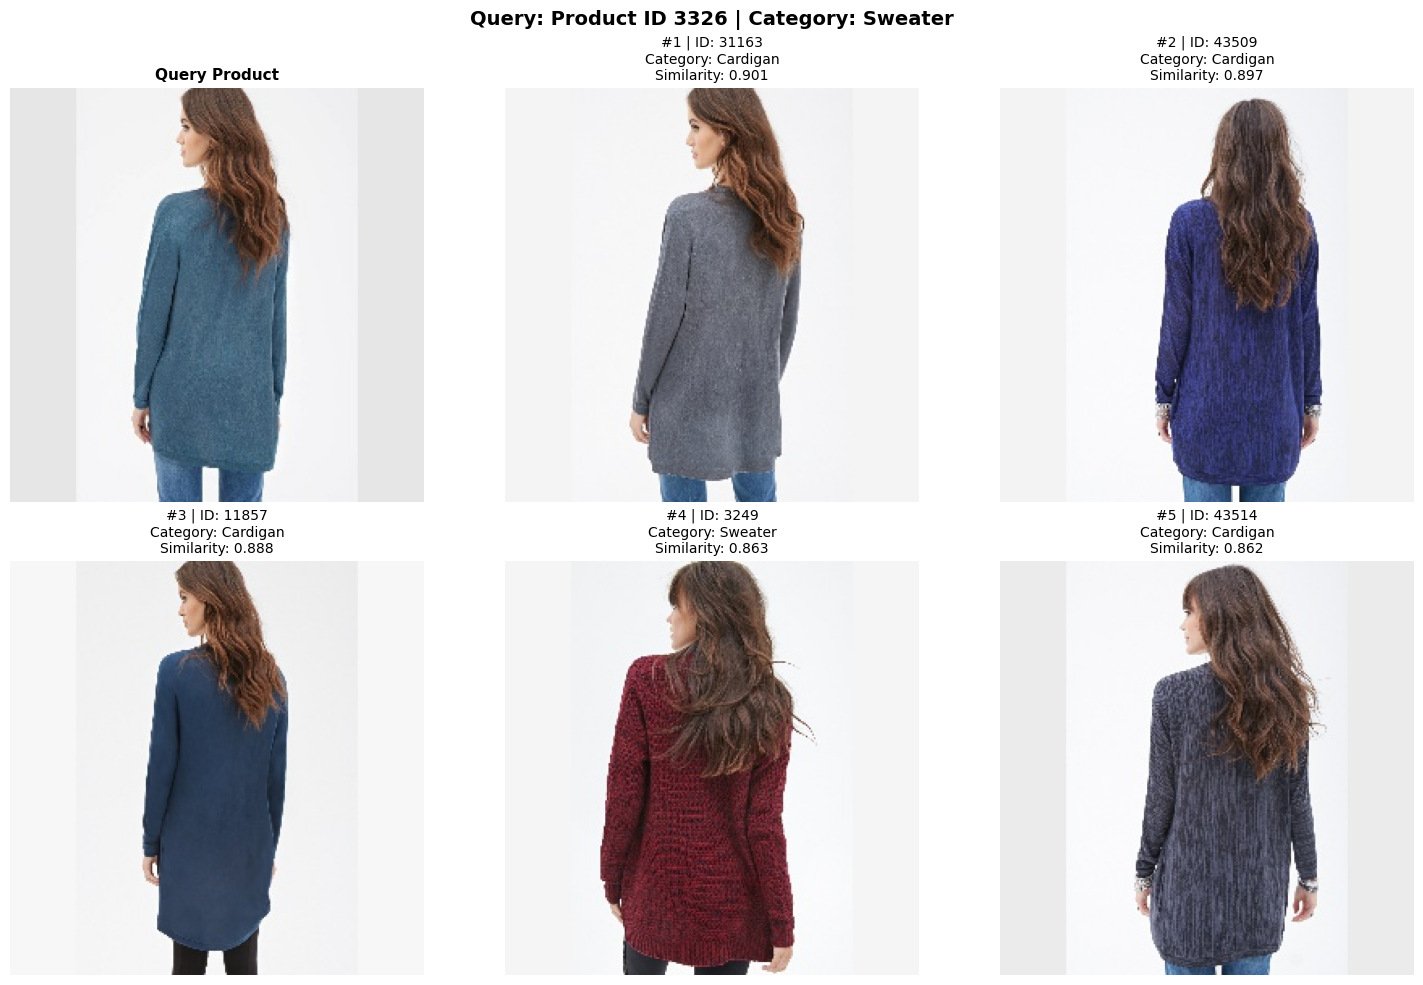

✓ Visualization complete!


In [13]:
## Visualize Query and Top 5 Recommendations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle(f"Query: Product ID {query_product['product_id']} | Category: {query_product['category']}", 
             fontsize=14, fontweight='bold')

# Display query product
query_img_path = DATA_DIR / query_product['image_path']
query_img = PILImage.create(query_img_path)
axes[0, 0].imshow(query_img)
axes[0, 0].set_title("Query Product", fontweight='bold', fontsize=11)
axes[0, 0].axis('off')

# Display top 5 recommendations
for idx, (ax, (_, row)) in enumerate(zip(axes.flatten()[1:], recommendations.iterrows())):
    rec_img_path = DATA_DIR / row['image_path']
    try:
        rec_img = PILImage.create(rec_img_path)
        ax.imshow(rec_img)
        similarity = 1 / (1 + row['distance'])  # Convert distance to similarity (0-1)
        ax.set_title(f"#{idx+1} | ID: {row['product_id']}\nCategory: {row['category']}\nSimilarity: {similarity:.3f}", 
                     fontsize=10)
    except Exception as e:
        ax.text(0.5, 0.5, f"Error loading image", ha='center', va='center')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("✓ Visualization complete!")